In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [92]:
data = pd.read_csv('../data/data.csv')

In [93]:
X,y = data.drop('Estado al egreso', axis=1), data['Estado al egreso']

In [94]:
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_models_loocv(X, y, model):
    results = {}
    
    y_true, y_pred = [], []
        
    for train_index, test_index in LeaveOneOut().split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
        model.fit(X_train, y_train)
        
        y_pred_fold = model.predict(X_test)
        y_true.append(y_test.values[0])
        y_pred.append(y_pred_fold[0])
        
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    results= {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        }

    return results

### RandomForestClassifier

In [95]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import make_scorer, f1_score

rf = RandomForestClassifier(random_state=1, class_weight='balanced')

params_rf = {
    'n_estimators': [10, 50, 100],
    'max_depth': [6, 10, 12],
    'min_samples_leaf': [2, 4, 6],
    'min_samples_split': [2, 4, 10],
    'criterion': ['gini', 'entropy']
}

rskf = RepeatedStratifiedKFold(n_splits=3,n_repeats=10,random_state=42)

grid_rf = GridSearchCV(rf, params_rf, cv=rskf, scoring='f1',n_jobs=-1)
grid_rf.fit(X,y)

c:\Users\amiro\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=3, random_state=42),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=1),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [6, 10, 12],
                         'min_samples_leaf': [2, 4, 6],
                         'min_samples_split': [2, 4, 10],
                         'n_estimators': [10, 50, 100]},
             scoring='f1')

In [96]:
grid_rf.best_score_

0.927878787878788

In [97]:
best_rf = grid_rf.best_estimator_

In [98]:
results_rf = evaluate_models_loocv(X,y,best_rf)
results_rf

{'accuracy': 0.8571428571428571,
 'precision': 0.8125,
 'recall': 1.0,
 'f1': 0.896551724137931}

In [108]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

best_rf.fit(X_scaled, y)

coefs = best_rf.feature_importances_
base_importances_rf = pd.Series(np.abs(coefs), index=X.columns).sort_values(ascending=False)
print(base_importances_rf)

Sofa                                           0.304532
# de hemoderivados  usados                     0.198051
Apache II                                      0.095104
componentes triada letal                       0.092484
Etiología del empaquetamiento                  0.049731
traumas asociado                               0.049722
Edad                                           0.049407
VAM                                            0.040285
Daño orgánico tubular asociado                 0.028273
Número de compresas utilizadas                 0.018122
App HTA                                        0.017952
App Cardiopatía Isquémica                      0.015007
Tiempo quirúrgico                              0.014800
Sexo                                           0.013642
Horas transcurridas al desempaquetamiento      0.006167
Presencia de hipotensión arterial o shock      0.005282
App AB                                         0.001439
Lesión de vía biliar asociada                  0

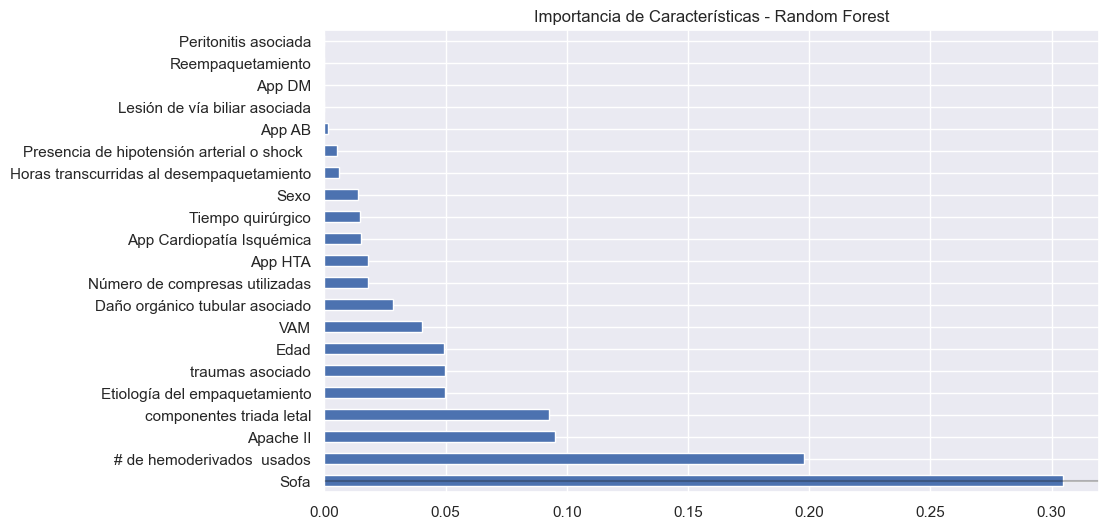


Coeficientes con signo:
                                        Feature  Coefficient  Abs_Coefficient
20                                         Sofa     0.304532         0.304532
14                   # de hemoderivados  usados     0.198051         0.198051
19                                    Apache II     0.095104         0.095104
15                     componentes triada letal     0.092484         0.092484
6                 Etiología del empaquetamiento     0.049731         0.049731
16                             traumas asociado     0.049722         0.049722
0                                          Edad     0.049407         0.049407
17                                          VAM     0.040285         0.040285
9                Daño orgánico tubular asociado     0.028273         0.028273
7                Número de compresas utilizadas     0.018122         0.018122
2                                       App HTA     0.017952         0.017952
5                     App Cardiopatía I

In [110]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.set(style='darkgrid')
base_importances_rf.plot(kind='barh')

plt.title('Importancia de Características - Random Forest')
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.show()

coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': best_rf.feature_importances_,
    'Abs_Coefficient': np.abs(best_rf.feature_importances_)
}).sort_values('Abs_Coefficient', ascending=False)

print("\nCoeficientes con signo:")
print(coef_df)

In [100]:
import pickle as pkl

with open('../models/rf.pkl', 'wb') as file:
    pkl.dump(best_rf, file)

### LogisticRegression

In [101]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=1, max_iter=10000)

params_lr = {
    'penalty': ['l2'],
    'C': [0.01, 0.1, 1],
    'class_weight': ['balanced']
}

grid_lr = GridSearchCV(lr, params_lr, cv=rskf, scoring='f1', n_jobs=-1)
grid_lr.fit(X, y)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=3, random_state=42),
             estimator=LogisticRegression(max_iter=10000, random_state=1),
             n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1], 'class_weight': ['balanced'],
                         'penalty': ['l2']},
             scoring='f1')

In [102]:
best_lr = grid_lr.best_estimator_

In [103]:
results_lr = evaluate_models_loocv(X,y,best_lr)
results_lr

{'accuracy': 0.8095238095238095,
 'precision': 0.8461538461538461,
 'recall': 0.8461538461538461,
 'f1': 0.8461538461538461}

In [111]:
X_scaled_lr = scaler.fit_transform(X)

best_lr.fit(X_scaled_lr, y)

coefs = best_lr.coef_[0]
base_importances_lr = pd.Series(np.abs(coefs), index=X.columns).sort_values(ascending=False)
print(base_importances_lr)

Sofa                                           1.167922
Apache II                                      0.864137
componentes triada letal                       0.640239
traumas asociado                               0.500368
# de hemoderivados  usados                     0.440114
App Cardiopatía Isquémica                      0.427281
Lesión de vía biliar asociada                  0.335322
Sexo                                           0.330776
Daño orgánico tubular asociado                 0.257865
Presencia de hipotensión arterial o shock      0.246408
Número de compresas utilizadas                 0.229517
VAM                                            0.228116
Etiología del empaquetamiento                  0.190049
Tiempo quirúrgico                              0.177943
Edad                                           0.166508
App DM                                         0.134249
Horas transcurridas al desempaquetamiento      0.041696
App AB                                         0

In [105]:
with open('../models/lr.pkl', 'wb') as file:
    pkl.dump(best_lr, file)


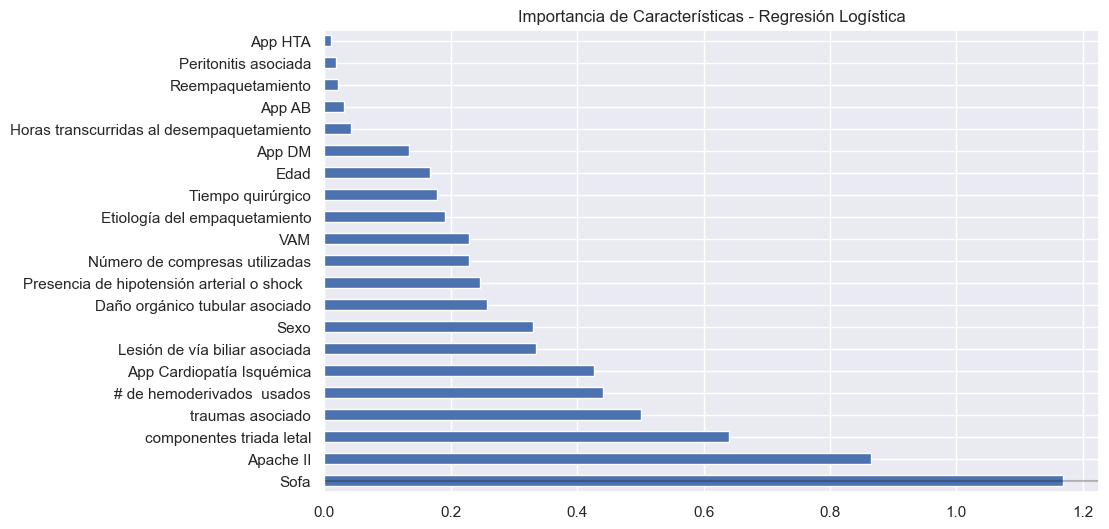


Coeficientes con signo:
                                        Feature  Coefficient  Abs_Coefficient
20                                         Sofa     1.167922         1.167922
19                                    Apache II     0.864137         0.864137
15                     componentes triada letal     0.640239         0.640239
16                             traumas asociado     0.500368         0.500368
14                   # de hemoderivados  usados     0.440114         0.440114
5                     App Cardiopatía Isquémica     0.427281         0.427281
11                Lesión de vía biliar asociada    -0.335322         0.335322
1                                          Sexo    -0.330776         0.330776
9                Daño orgánico tubular asociado    -0.257865         0.257865
12  Presencia de hipotensión arterial o shock       0.246408         0.246408
7                Número de compresas utilizadas    -0.229517         0.229517
17                                     

In [106]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.set(style='darkgrid')
base_importances_lr.plot(kind='barh')

plt.title('Importancia de Características - Regresión Logística')
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.show()

coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': best_lr.coef_[0],
    'Abs_Coefficient': np.abs(best_lr.coef_[0])
}).sort_values('Abs_Coefficient', ascending=False)

print("\nCoeficientes con signo:")
print(coef_df)